In [1]:
#imports

import yfinance as yf
from scipy import stats
import datetime as dt
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns



In [2]:
#parameters

ticker_list=['0700.HK','1810.HK','BABA','TME','FB']
#ticker_list=['QQQ','SPLV','TLT','GLD','GSG','BTC-USD','2822.HK','MCHI']
focus='0700.HK'

#init
sns.set_theme(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=True, 
            rc={'figure.figsize':(15,10)})

In [3]:
#get price data
df_price=pd.DataFrame()
for ticker in ticker_list:
    data=yf.download(ticker)
    df_price[ticker]=data['Close'].dropna()
    df_return=df_price.pct_change().dropna()



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:

def cal_rolling_cov(s1,s2,period):
    start_date=s1.index[0]
    cov=dict()
    while start_date<s1.index.max()-dt.timedelta(days=period):
        end_date=start_date+dt.timedelta(days=period)
        a1=s1[start_date:end_date]
        a2=s2[start_date:end_date]
        cov[end_date]=stats.pearsonr(a1, a2)[0]
        start_date=start_date+dt.timedelta(days=1)
    cov=pd.Series(cov)
    cov.name=s1.name+'-'+s2.name

    return pd.Series(cov)


In [5]:
# Calculate correlations
resample='1W'
days=90

df_price_rs=df_price.resample(resample).last()
df_price_rs
df_return=df_price_rs.pct_change().dropna()


df_cov=pd.DataFrame()

for ticker1 in ticker_list:
    for ticker2 in ticker_list:
        if ticker2+'_'+ticker1 in df_cov.columns:
            df_cov[ticker1+'_'+ticker2]=df_cov[ticker2+'_'+ticker1]
        else:
            df_cov[ticker1+'_'+ticker2]=cal_rolling_cov(df_return[ticker1],df_return[ticker2],days)


Text(0.5, 1.0, 'Rolling 90 Days Correlation based on 1W Return')

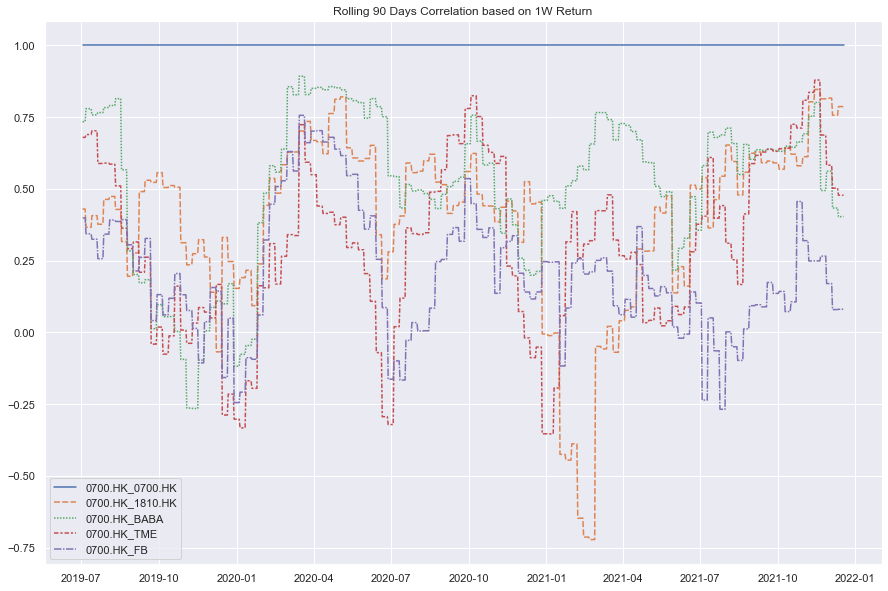

In [6]:
pd.options.display.float_format = '{:,.2f}'.format
df_cov_current=pd.DataFrame(index=ticker_list)
for ticker1 in ticker_list:
    for ticker2 in ticker_list:
        df_cov_current.loc[ticker1,ticker2]=df_cov[ticker1+'_'+ticker2].iloc[-1]

df_cov_current

col=[]
for ticker in ticker_list:
    col.append(focus+"_"+ticker)
df_cov_filtered=df_cov[col]
plot=sns.lineplot(data=df_cov_filtered.loc[dt.date.today()-dt.timedelta(days=days*10):])
plt.title('Rolling %i Days Correlation based on %s Return'%(days,resample))